cuda
Epoch [1/100], Training Loss Real: 0.0292, Test Loss Real: 0.0188, Training Loss Imag: 0.0272, Test Loss Imag: 0.0186
Epoch [2/100], Training Loss Real: 0.0146, Test Loss Real: 0.0118, Training Loss Imag: 0.0146, Test Loss Imag: 0.0116
Epoch [3/100], Training Loss Real: 0.0110, Test Loss Real: 0.0094, Training Loss Imag: 0.0109, Test Loss Imag: 0.0093
Epoch [4/100], Training Loss Real: 0.0090, Test Loss Real: 0.0082, Training Loss Imag: 0.0090, Test Loss Imag: 0.0081
Epoch [5/100], Training Loss Real: 0.0077, Test Loss Real: 0.0087, Training Loss Imag: 0.0078, Test Loss Imag: 0.0087
Epoch [6/100], Training Loss Real: 0.0071, Test Loss Real: 0.0075, Training Loss Imag: 0.0071, Test Loss Imag: 0.0071
Epoch [7/100], Training Loss Real: 0.0064, Test Loss Real: 0.0068, Training Loss Imag: 0.0065, Test Loss Imag: 0.0068
Epoch [8/100], Training Loss Real: 0.0059, Test Loss Real: 0.0061, Training Loss Imag: 0.0060, Test Loss Imag: 0.0062
Epoch [9/100], Training Loss Real: 0.0056, Test Los

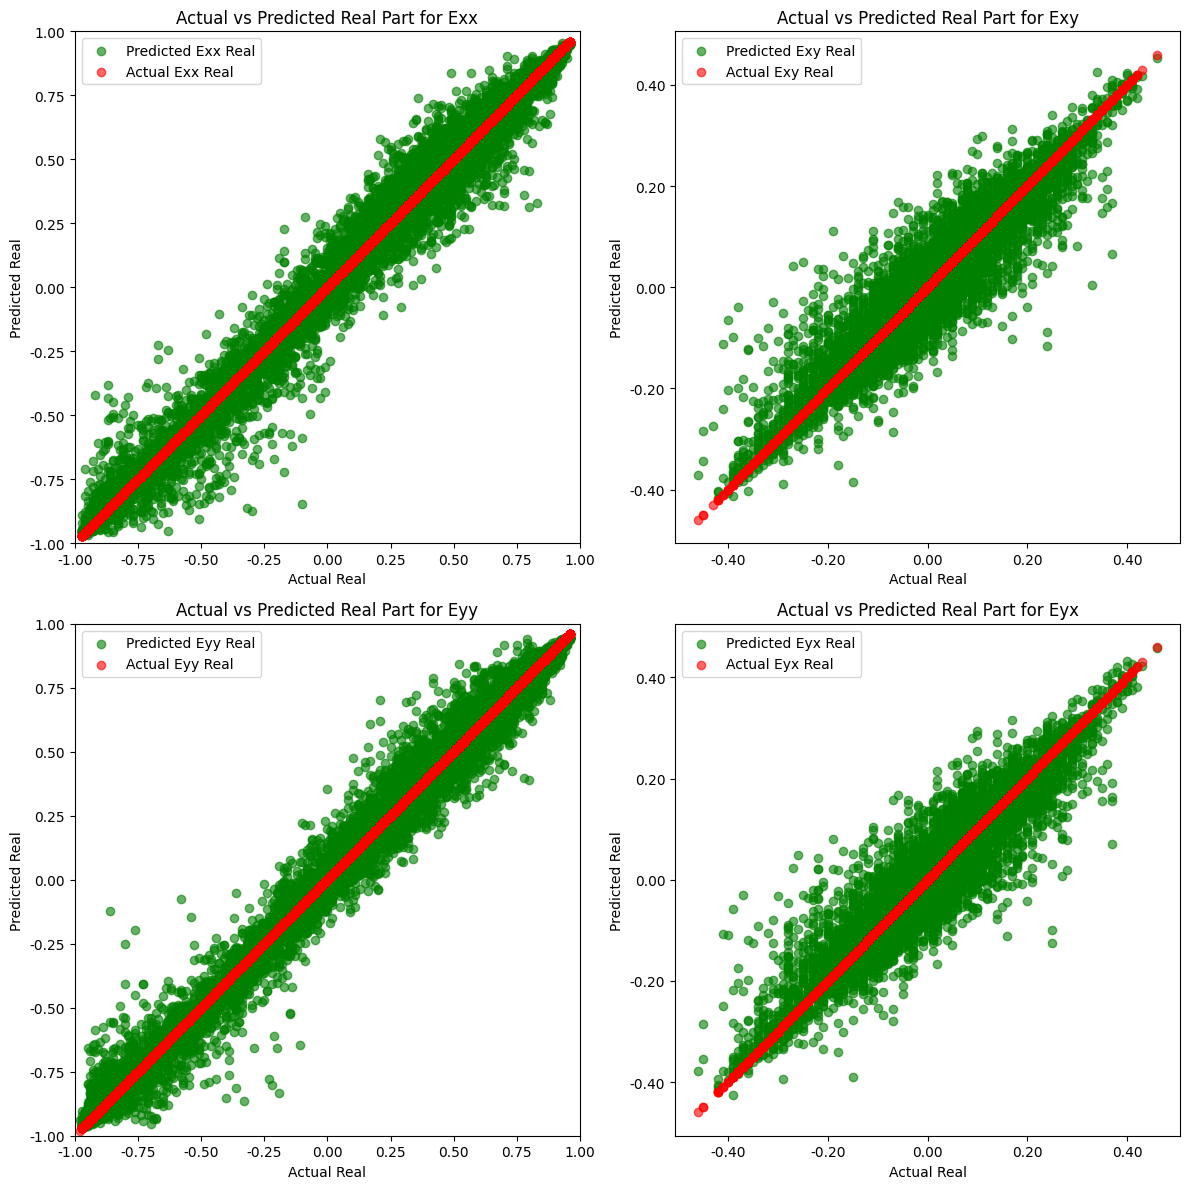

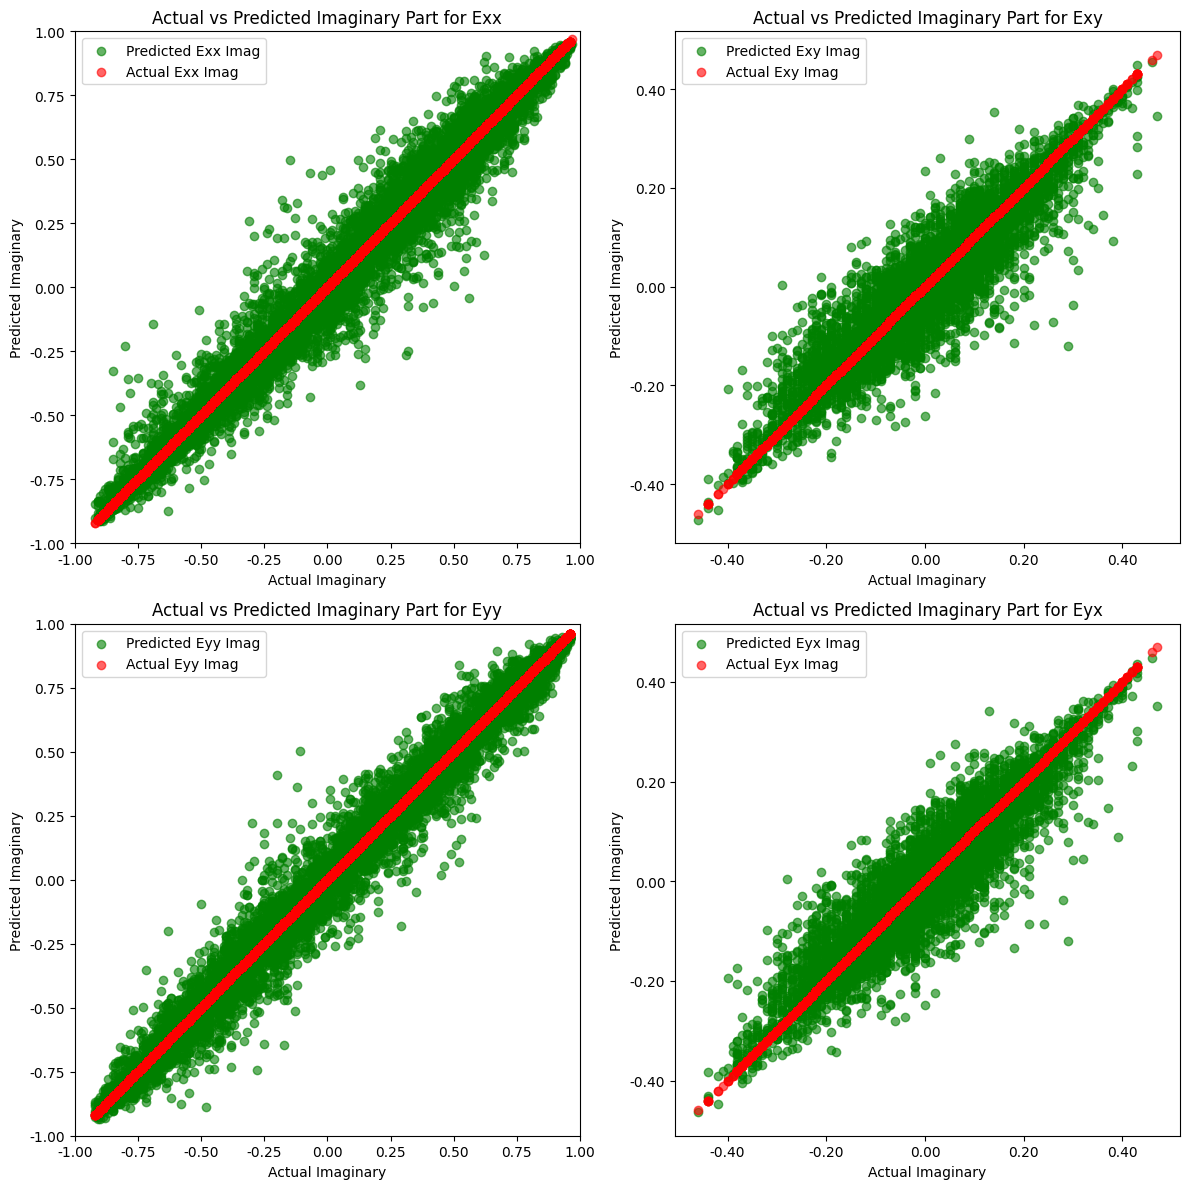

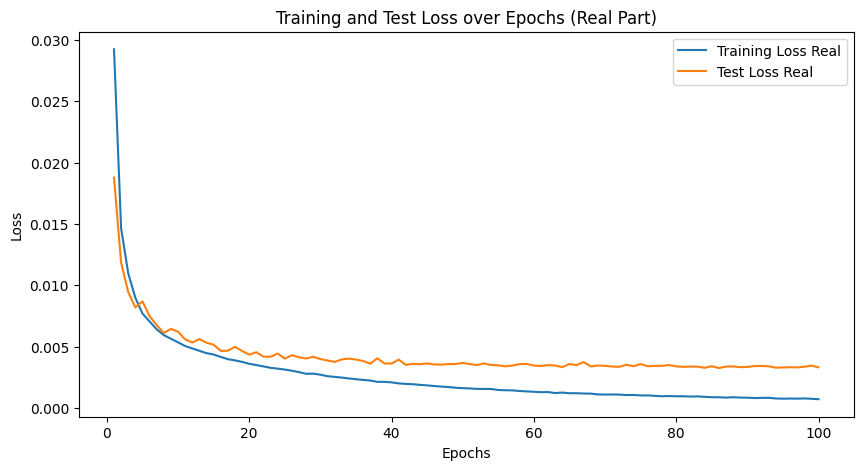

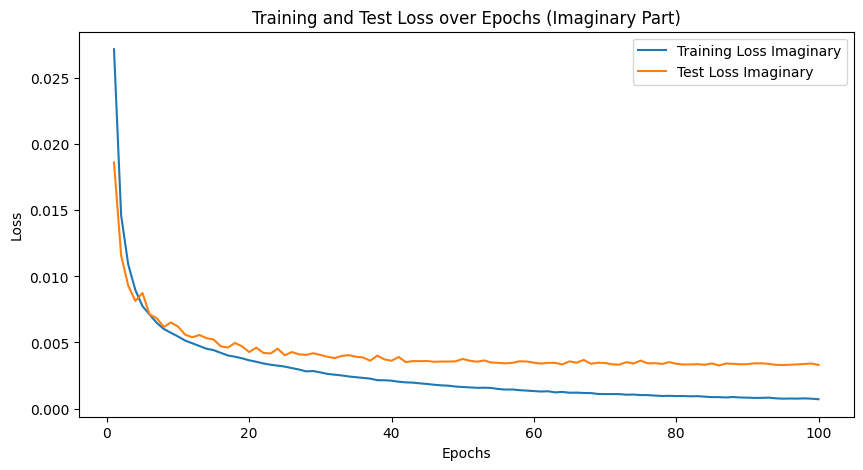

In [1]:
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
# Start time
start_time = time.time()
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Function to process image file
def process_image_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    images = []
    image = []
    for line in lines:
        row = [int(pixel) for pixel in line.strip().split(',')]
        image.append(row)
        if len(image) == 64:
            images.append(image)
            image = []
    images = np.array(images, dtype=np.float32)
    images = images.reshape(-1, 1, 64, 64)  # -1 to automatically determine the number of images
    return images

file_path1 = 'Simulator_Data/Final_metasurface_V5.txt'
images = process_image_file(file_path1)

# Function to parse complex number
def parse_complex_number(s):
    complex_match = re.match(r'([+-]?\d+(\.\d+)?)([+-]\d+(\.\d+)?)i', s)
    if complex_match:
        real_part = float(complex_match.group(1))
        imag_part = float(complex_match.group(3))
        return complex(real_part, imag_part)
    real_match = re.match(r'([+-]?\d+(\.\d+)?)(?![i])', s)
    if real_match:
        real_part = float(real_match.group(1))
        return complex(real_part, 0)
    raise ValueError(f"Invalid complex number format: {s}")

file_path2 = 'Simulator_Data/rounded_Final_label_complex_V5.txt'
with open(file_path2, 'r') as file:
    lines = file.readlines()
complex_numbers = [parse_complex_number(num) for line in lines for num in line.strip().split()]

real_parts = [num.real for num in complex_numbers]
imag_parts = [num.imag for num in complex_numbers]

labels_real = np.array(real_parts, dtype=np.float32).reshape(-1, 64)
labels_imag = np.array(imag_parts, dtype=np.float32).reshape(-1, 64)

# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels_real, labels_imag):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels_real = torch.tensor(labels_real, dtype=torch.float32)
        self.labels_imag = torch.tensor(labels_imag, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label_real = self.labels_real[idx]
        label_imag = self.labels_imag[idx]
        return image, label_real, label_imag

dataset = ImageDataset(images, labels_real, labels_imag)
train_size = int(0.9 * len(dataset))             # split 90/10 **********************************************************************************
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # batch size *********************************************************************************************************************

# Define ResNetBlock1
class ResNetBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity_downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        if self.identity_downsample is not None:
            identity = self.identity_downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

# Define ResNetBlock2
class ResNetBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        if self.conv3 is not None:
            identity = self.conv3(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

# Define the entire network
class FinalCNN(nn.Module):
    def __init__(self):
        super(FinalCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3) # kernel size ********************************************************************************************************
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResNetBlock1(in_channels=64, out_channels=64)
        self.layer2 = ResNetBlock2(in_channels=64, out_channels=128)
        self.layer3 = ResNetBlock1(in_channels=128, out_channels=256)
        self.layer4 = ResNetBlock2(in_channels=256, out_channels=128)
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        #self.dropout = nn.Dropout(0.5) # dropout ************************************************************************************************************************
        self.fc3 = nn.Linear(128, 128)  # 64 for real and 64 for imaginary

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = torch.tanh(self.fc3(x))  # Clamping the output to be within [-1, 1]
        return x

# Initialize the model, loss function, and optimizer
model = FinalCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001) # learning rate ********************************************************************************************************

# Lists to store training and test loss
train_losses_real = []
train_losses_imag = []
test_losses_real = []
test_losses_imag = []



# Training and testing loop
num_epochs = 100   # epoch *******************************************************************************************************
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss_real = 0.0
    running_train_loss_imag = 0.0
    for images, labels_real, labels_imag in train_loader:
        images, labels_real, labels_imag = images.to(device), labels_real.to(device), labels_imag.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs_real = outputs[:, :64]
        outputs_imag = outputs[:, 64:]
        loss_real = criterion(outputs_real, labels_real)
        loss_imag = criterion(outputs_imag, labels_imag)
        loss_real.backward(retain_graph=True)
        loss_imag.backward()
        optimizer.step()
        running_train_loss_real += loss_real.item()
        running_train_loss_imag += loss_imag.item()
        
    avg_train_loss_real = running_train_loss_real / len(train_loader)
    avg_train_loss_imag = running_train_loss_imag / len(train_loader)
    
    train_losses_real.append(avg_train_loss_real)
    train_losses_imag.append(avg_train_loss_imag)

    # Testing phase
    model.eval()
    running_test_loss_real = 0.0
    running_test_loss_imag = 0.0
    actual_real = []
    actual_imag = []
    predicted_real = []
    predicted_imag = []

    with torch.no_grad():
        for images, labels_real, labels_imag in test_loader:
            images, labels_real, labels_imag = images.to(device), labels_real.to(device), labels_imag.to(device)
            outputs = model(images)
            outputs_real = outputs[:, :64]
            outputs_imag = outputs[:, 64:]

            # Collect actual and predicted values
            actual_real.append(labels_real.cpu().numpy())
            actual_imag.append(labels_imag.cpu().numpy())
            predicted_real.append(outputs_real.cpu().numpy())
            predicted_imag.append(outputs_imag.cpu().numpy())

            loss_real = criterion(outputs_real, labels_real)
            loss_imag = criterion(outputs_imag, labels_imag)
            running_test_loss_real += loss_real.item()
            running_test_loss_imag += loss_imag.item()
    
    avg_test_loss_real = running_test_loss_real / len(test_loader)
    avg_test_loss_imag = running_test_loss_imag / len(test_loader)
    test_losses_real.append(avg_test_loss_real)
    test_losses_imag.append(avg_test_loss_imag)
    
    # Print losses for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss Real: {avg_train_loss_real:.4f}, Test Loss Real: {avg_test_loss_real:.4f}, Training Loss Imag: {avg_train_loss_imag:.4f}, Test Loss Imag: {avg_test_loss_imag:.4f}')


finland_timezone = pytz.timezone('Europe/Helsinki')
current_time = datetime.now(finland_timezone).strftime('%d_%H%M')    

# After the training loop
model_path = f'Simulator_trained/model_{current_time}.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Execution time
# End time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")


# Save Loss statistics to a text file
with open(f'Simulator_Result/Loss_statistics_{current_time}.txt', 'w') as f:

    f.write("Loss Statistics:\n")
    f.write(f"Training loss Real:{avg_train_loss_real:.4f}\n")
    f.write(f"Training loss imag:{avg_train_loss_imag:.4f}\n")
    f.write(f"Test loss real:{avg_test_loss_real:.4f}\n")
    f.write(f"Test loss imag:{avg_test_loss_imag:.4f}\n")
    


# Convert collected lists to numpy arrays
actual_real = np.concatenate(actual_real, axis=0)
actual_imag = np.concatenate(actual_imag, axis=0)
predicted_real = np.concatenate(predicted_real, axis=0)
predicted_imag = np.concatenate(predicted_imag, axis=0)

# Create subplots for actual vs predicted for real parts
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Exx Real
axs[0, 0].scatter(actual_real[:, :16].flatten(), predicted_real[:, :16].flatten(), color='green',label='Predicted Exx Real', alpha=0.6)
axs[0, 0].scatter(actual_real[:, :16].flatten(), actual_real[:, :16].flatten(), color='red', label='Actual Exx Real',alpha=0.6)
axs[0, 0].set_title('Actual vs Predicted Real Part for Exx')
axs[0, 0].set_xlabel('Actual Real')
axs[0, 0].set_ylabel('Predicted Real')
axs[0, 0].legend()
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

# Exy Real
axs[0, 1].scatter(actual_real[:, 16:32].flatten(), predicted_real[:, 16:32].flatten(), color='green',label='Predicted Exy Real', alpha=0.6)
axs[0, 1].scatter(actual_real[:, 16:32].flatten(), actual_real[:, 16:32].flatten(), color='red',label='Actual Exy Real', alpha=0.6)
axs[0, 1].set_title('Actual vs Predicted Real Part for Exy')
axs[0, 1].set_xlabel('Actual Real')
axs[0, 1].set_ylabel('Predicted Real')
axs[0, 1].legend()
#axs[0, 1].set_xlim([-1, 1])
#axs[0, 1].set_ylim([-1, 1])
axs[0, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
axs[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

# Eyy Real
axs[1, 0].scatter(actual_real[:, 32:48].flatten(), predicted_real[:, 32:48].flatten(), color='green',label='Predicted Eyy Real', alpha=0.6)
axs[1, 0].scatter(actual_real[:, 32:48].flatten(), actual_real[:, 32:48].flatten(), color='red',label='Actual Eyy Real', alpha=0.6)
axs[1, 0].set_title('Actual vs Predicted Real Part for Eyy')
axs[1, 0].set_xlabel('Actual Real')
axs[1, 0].set_ylabel('Predicted Real')
axs[1, 0].legend()
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
axs[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

# Eyx Real
axs[1, 1].scatter(actual_real[:, 48:].flatten(), predicted_real[:, 48:].flatten(), color='green',label='Predicted Eyx Real', alpha=0.6)
axs[1, 1].scatter(actual_real[:, 48:].flatten(), actual_real[:, 48:].flatten(), color='red', label='Actual Eyx Real',alpha=0.6)
axs[1, 1].set_title('Actual vs Predicted Real Part for Eyx')
axs[1, 1].set_xlabel('Actual Real')
axs[1, 1].set_ylabel('Predicted Real')
axs[1, 1].legend()
#axs[1, 1].set_xlim([-1, 1])
#axs[1, 1].set_ylim([-1, 1])
axs[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
axs[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

plt.tight_layout()
plt.savefig(f'Simulator_Result/Real_Val_{current_time}.png')
plt.show()

# Create subplots for actual vs predicted for imaginary parts
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Exx Imag
axs[0, 0].scatter(actual_imag[:, :16].flatten(), predicted_imag[:, :16].flatten(), color='green',label='Predicted Exx Imag', alpha=0.6)
axs[0, 0].scatter(actual_imag[:, :16].flatten(), actual_imag[:, :16].flatten(), color='red', label='Actual Exx Imag',alpha=0.6)
axs[0, 0].set_title('Actual vs Predicted Imaginary Part for Exx')
axs[0, 0].set_xlabel('Actual Imaginary')
axs[0, 0].set_ylabel('Predicted Imaginary')
axs[0, 0].legend()
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

# Exy Imag
axs[0, 1].scatter(actual_imag[:, 16:32].flatten(), predicted_imag[:, 16:32].flatten(), color='green',label='Predicted Exy Imag', alpha=0.6)
axs[0, 1].scatter(actual_imag[:, 16:32].flatten(), actual_imag[:, 16:32].flatten(), color='red',label='Actual Exy Imag', alpha=0.6)
axs[0, 1].set_title('Actual vs Predicted Imaginary Part for Exy')
axs[0, 1].set_xlabel('Actual Imaginary')
axs[0, 1].set_ylabel('Predicted Imaginary')
axs[0, 1].legend()
#axs[0, 1].set_xlim([-1, 1])
#axs[0, 1].set_ylim([-1, 1])
axs[0, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
axs[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

# Eyy Imag
axs[1, 0].scatter(actual_imag[:, 32:48].flatten(), predicted_imag[:, 32:48].flatten(), color='green',label='Predicted Eyy Imag', alpha=0.6)
axs[1, 0].scatter(actual_imag[:, 32:48].flatten(), actual_imag[:, 32:48].flatten(), color='red',label='Actual Eyy Imag', alpha=0.6)
axs[1, 0].set_title('Actual vs Predicted Imaginary Part for Eyy')
axs[1, 0].set_xlabel('Actual Imaginary')
axs[1, 0].set_ylabel('Predicted Imaginary')
axs[1, 0].legend()
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
axs[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

# Eyx Imag
axs[1, 1].scatter(actual_imag[:, 48:].flatten(), predicted_imag[:, 48:].flatten(), color='green',label='Predicted Eyx Imag', alpha=0.6)
axs[1, 1].scatter(actual_imag[:, 48:].flatten(), actual_imag[:, 48:].flatten(), color='red', label='Actual Eyx Imag',alpha=0.6)
axs[1, 1].set_title('Actual vs Predicted Imaginary Part for Eyx')
axs[1, 1].set_xlabel('Actual Imaginary')
axs[1, 1].set_ylabel('Predicted Imaginary')
axs[1, 1].legend()
#axs[1, 1].set_xlim([-1, 1])
#axs[1, 1].set_ylim([-1, 1])
axs[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))
axs[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}'))

plt.tight_layout()
plt.savefig(f'Simulator_Result/Imag_Val_{current_time}.png')
plt.show()

# Plot training and test loss over epochs for real parts
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_real, label='Training Loss Real')
plt.plot(range(1, num_epochs + 1), test_losses_real, label='Test Loss Real')
plt.legend()
plt.title('Training and Test Loss over Epochs (Real Part)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f'Simulator_Result/TVLoss_real_{current_time}.png')
plt.show()

# Plot training and test loss over epochs for imaginary parts
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_imag, label='Training Loss Imaginary')
plt.plot(range(1, num_epochs + 1), test_losses_imag, label='Test Loss Imaginary')
plt.legend()
plt.title('Training and Test Loss over Epochs (Imaginary Part)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f'Simulator_Result/TVLoss_imag_{current_time}.png')
plt.show()

